## Introduction
In this notebook we will create the dataset class used to feed slices and corresponding segmentation masks to the network during training

## Imports

* pathlib for easy path handling
* torch for dataset creation
* numpy for file loading and processing
* imgaug to set the random seed
* SegmentationMapsOnImage from imgaug to augment the segmentation map

In [1]:
from pathlib import Path

import torch
import numpy as np
import imgaug
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

## DataSet Creation
We need to implement the following functionality:
1. Create a list of all 2D slices. To do so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [17]:
class CardiacDataset(torch.utils.data.Dataset):
    def __init__(self, root, augment_params):
        # Constructor: receives the dataset root (train or val) and the augmentation parameters
        self.all_files = self.extract_files(root)  # List of paths to all slices
        self.augment_params = augment_params       # Augmentation parameters
    
    @staticmethod
    def extract_files(root):
        """
        Extracts the paths to all slices (.npy files) under the given root directory.
        (Root should point to either train or val directory.)
        
        @staticmethod is used because this method does not depend on the instance (self) 
        or the class itself. It only needs the 'root' argument.
        """
        files = []
        for subject in root.glob("*"):   # Iterate over all subjects (one folder per patient)
            slice_path = subject/"slices"  # Access the 'slices' folder for each subject
            for slice in slice_path.glob("*.npy"):  # Find all .npy slice files
                files.append(slice)     # Append the path to the list
        return files
    
    @staticmethod
    def change_img_to_label_path(path):
        """
        Given a path to a slice, replace 'slices' with 'masks' to get the corresponding mask path.
        
        @staticmethod is used because this function simply transforms a given path
        and does not require access to the class or instance attributes.
        """
        parts = list(path.parts)  # Split the path into parts
        parts[parts.index("slices")] = "masks"  # Replace "slices" with "masks" in the path
        return Path(*parts)       # Reconstruct the path

    def augment(self, slice, mask):
        """
        Applies the same augmentation to both the slice and the corresponding mask.
        A manual seed is initialized to ensure that different DataLoader workers 
        do not generate the same random augmentations (common PyTorch issue).
        """
        random_seed = torch.randint(0, 1000000, (1,)).item()  # Generate a random seed
        imgaug.seed(random_seed)  # Set the seed for imgaug to ensure randomness
        
        mask = SegmentationMapsOnImage(mask, mask.shape)  # Wrap the mask for imgaug
        slice_aug, mask_aug = self.augment_params(image=slice, segmentation_maps=mask)  # Apply augmentation
        mask_aug = mask_aug.get_arr()  # Convert back to a NumPy array
        return slice_aug, mask_aug

    def __len__(self):
        """
        Returns the total number of slices available in the dataset.
        Required for PyTorch's DataLoader to work properly.
        """
        return len(self.all_files)
    
    def __getitem__(self, idx):
        """
        Given an index, returns the corresponding (augmented) slice and its mask.
        
        - Loads the slice and mask from .npy files.
        - Applies augmentations if they are provided.
        - Adds an extra channel dimension (C, H, W) since the original slices are (H, W),
          and PyTorch expects inputs of shape (C, H, W).
        """
        file_path = self.all_files[idx]  # Path to the slice
        mask_path = self.change_img_to_label_path(file_path)  # Path to the corresponding mask
        
        slice = np.load(file_path).astype(np.float32)  # Load slice and convert to float32
        mask = np.load(mask_path)  # Load mask
        
        if self.augment_params:
            slice, mask = self.augment(slice, mask)  # Apply augmentation if needed
        
        return np.expand_dims(slice, 0), np.expand_dims(mask, 0)  # Add channel dimension (C, H, W)


We now proceed to test the `CardiacDataset` class by defining a simple data augmentation routine and creating a dataset instance.

First, we define a sequence of augmentations using `imgaug`, including:
- **Affine transformations**: random scaling (zoom in/out) and rotation up to 45 degrees.
- **Elastic transformations**: random elastic deformations to simulate realistic anatomical variations.

Then, we create a `CardiacDataset` object using the preprocessed training slices, applying the defined augmentation sequence.

This will allow us to verify that the dataset correctly loads, augments, and returns the 2D slices and corresponding masks with consistent transformations.

In [18]:
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa


In [19]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # Zoom in or out
               rotate=(-45, 45)),  # Rotate up to 45 degrees
    iaa.ElasticTransformation()  # Random Elastic Deformations
                ])


In [24]:
path = Path("../data/Preprocessed/train/")
train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 1932 train images and 339 val images


Finally, we can visualize our dataset.
To make sure that the augmentation works properly, we access the same dataset element multiple times and visualize the augmented images and masks.

Please chose an index where the left atrium is visible

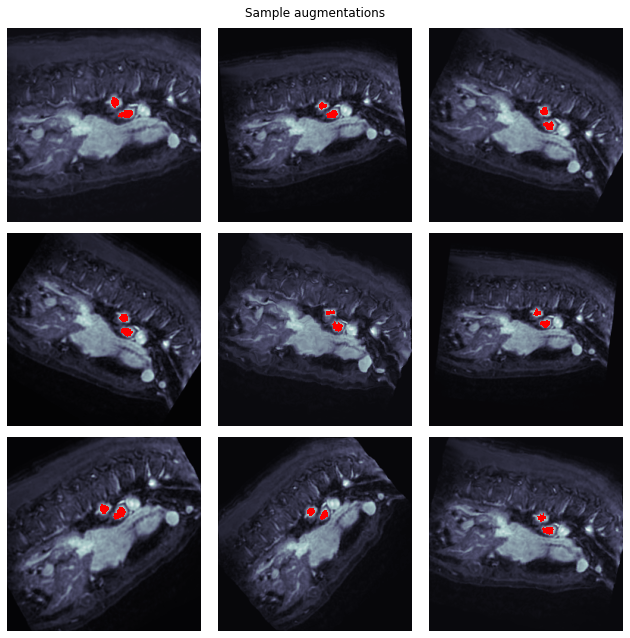

In [22]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        slice, mask = dataset[3]
        mask_ = np.ma.masked_where(mask==0, mask)
        axis[i][j].imshow(slice[0], cmap="bone")
        axis[i][j].imshow(mask_[0], cmap="autumn")
        axis[i][j].axis("off")

fig.suptitle("Sample augmentations")
plt.tight_layout()


Nice!
With above dataset we can finally create the model and train the AtriumSegmenter